In [11]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:80% !important;}</style>'))


In [20]:
''' 
This script will parse through the results folder returned from the pipeline execution and provide a list of 
the jobs that failed to complete.
Save the missing job numbers into a csv. 7361 jobs were supposed to run
'''
import os
import numpy as np
import pandas as pd

results = os.listdir('/home/toyonaga/scratch/pipeline/results')
compare = np.arange(int(input('how many jobs ran?')))

job_nums = [] #will be an int array 
for filename in results:
    try:
        start = filename.find('_') + 1 
        end = filename.find('.', start)
        job_nums.append(int(filename[start:end]))
    except:
        print('err')
        continue
print(len(job_nums))

missing = [] #list of jobs that didnt complete
for i in compare:
        if compare[i] not in job_nums:
            missing.append(compare[i])
            
print('missed this many jobs: '+ str(len(missing)))


failed = {'job':missing}

df =pd.DataFrame(data=failed)   
df.to_csv('missed_jobs.csv', index= False)

how many jobs ran? 7363


2971
missed this many jobs: 4392


In [4]:
data, hdr = fits.getdata(DWNLD_PATH + str(2) + ".fits", 1, header=True) #'sci' image[1] data and header

In [46]:
jobs = pd.read_csv('/home/toyonaga/projects/def-sfabbro/toyonaga/HSTLens/CC_batch_processing/missed_jobs.csv')
jobs['job'][1]+2

7

In [22]:
from IPython import display
import pandas as pd
import os
import time 
import subprocess
from astropy import wcs
from astropy.io import fits
from astropy.nddata.utils import Cutout2D
import numpy as np
import random
import matplotlib.pyplot as plt
from astropy.visualization import (ZScaleInterval, ImageNormalize)

DWNLD_PATH = "dwnlds/c_"
RESULTS_PATH = "/home/toyonaga/scratch/pipeline/results/"# '/home/toyonaga/scratch/pipeline/results_recover_2/'#
start = int(input('start from this results file '))
end = int(input("end at this results file "))
CSV_PATH="test_csv" #shouldn't have to change

OUT_PATH_1 = "class_1/c_"
OUT_PATH_2 = "class_2/c_"
OUT_PATH_3 = "class_3/c_" #crowded
OUT_PATH_4 = "class_4/c_"
OUT_PATH_5 = "class_5/c_"
OUT_PATH_6 = "class_6/c_"
OUT_PATH_7 = "class_7/c_"
OUT_PATH_8 = "class_8/c_"
OUT_PATH_9 = "class_9/c_" #general fp
OUT_PATH_22 = "class_22/c_" #main source and small satellite source (confused as arclet)
OUT_PATH_33 = "class_33/c_" # single bright source and faint background
im_info = pd.read_csv(CSV_PATH)
# count=0
# for job in range(end-start):
   
#     '''populate coordinate dict with result file info'''

#     try:
#         crd_dict = get_positives(RESULTS_PATH+"results_"+str(job+start)+".out")
#         print(len(crd_dict['ra']))
#         count+=len(crd_dict['prb'])
#     except:
#         print('missing results from job: '+str(job))
#         continue

start from this results file  3660
end at this results file  4000


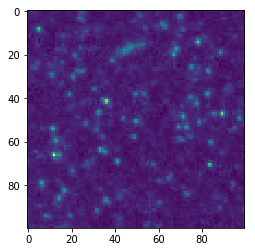

0.9614331126213074|| logscale =18, log black=19, exit=20, job: 3666 j9ov16010_drz.fits 2


missing results from job: 3667
missing results from job: 3668
missing results from job: 3669
14
14
dwnlding image 3670


In [ ]:
def dwnld(entry): 
    subprocess.check_output(["wget", "-O",DWNLD_PATH+str(entry)+ ".fits" ,
                             "http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/MAST/HST/product/"+
                             im_info['obj_name'][entry]+"_drz.fits"]) 

def get_positives(filename):
    #get coords of pred above 0.9
    crd_dict = {"ra": [], "dec":[], "obj_name":[], "prb_1":[] , "prb_2":[] , "prb_3":[] } 
    df = pd.read_csv(filename, sep = ',')
    for row in range(len(df)):
        if (float(df['prb_1'][row]) >= 0.67) :#and (float(df['prb'][row])<0.95) :
            crd_dict['prb_1'].append(df['prb_1'][row])
            crd_dict['ra'].append(df['ra'][row])
            crd_dict['dec'].append(df['dec'][row])
            crd_dict['obj_name'].append(df['obj_name'][row])
    print(len(crd_dict['ra']))
    return crd_dict

        
for job in range(end-start):
   
    '''populate coordinate dict with result file info'''
    try:
        crd_dict = get_positives(RESULTS_PATH+"results_"+str(job+start)+".out")
        print(len(crd_dict['ra']))
    except:
        print('missing results from job: '+str(job+start))
        continue
        
    if len(crd_dict['ra'])<1: #dont download anything if no candidates
        continue
        
    '''download image cutouts based on the file names''' 
    fails=0
    print("dwnlding image " + str(job+start))
    try: 
        dwnld(job+start)
    except:
        fails+=1
        print("Failed")
        
        print("failed: "+str(fails))
        continue    
        
    '''make 100x100 boxes'''
    data, hdr = fits.getdata(DWNLD_PATH + str(job+start) + ".fits", 1, header=True) #'sci' image[1] data and header
    w = wcs.WCS(hdr)
    exit=False
    skip=False
    for cutout in range(len(crd_dict["obj_name"])):
        try:                                

            pixcrd2 = w.wcs_world2pix([[float(crd_dict['ra'][cutout]), float(crd_dict['dec'][cutout])]], 0)
            centered_cut = Cutout2D(data, (pixcrd2[0][0], pixcrd2[0][1]), (100, 100))
            
            ims=centered_cut.data
#             print(crd_dict['prb'][cutout])

            
            display.clear_output(wait=True)
            plt.imshow(ims) 
            plt.pause(0.10)
            while(1):
                ans = int(input(str(crd_dict['prb_1'][cutout])+"|| logscale =18, log black=19, exit=20, job: "+str(job+start)+" "+crd_dict['obj_name'][cutout]))

                if ans ==1:
                    fits.writeto(OUT_PATH_1+ str(crd_dict['ra'][cutout]) + "_" + str(crd_dict['dec'][cutout]) +'.fits',centered_cut.data, header=hdr, overwrite =True)
                    
                    break
                if ans ==2:
                    skip=True# fits.writeto(OUT_PATH_2+ str(crd_dict['ra'][cutout]) + "_" + str(crd_dict['dec'][cutout]) +'.fits',centered_cut.data, header=hdr, overwrite =True)
                    break
#                 if ans ==3:
#                     fits.writeto(OUT_PATH_3+ str(crd_dict['ra'][cutout]) + "_" + str(crd_dict['dec'][cutout]) +'.fits',centered_cut.data, header=hdr, overwrite =True)
#                     break
#                 if ans ==4:
#                     fits.writeto(OUT_PATH_4+ str(crd_dict['ra'][cutout]) + "_" + str(crd_dict['dec'][cutout]) +'.fits',centered_cut.data, header=hdr, overwrite =True)
#                     break
#                 if ans ==5:
#                     fits.writeto(OUT_PATH_5+ str(crd_dict['ra'][cutout]) + "_" + str(crd_dict['dec'][cutout]) +'.fits',centered_cut.data, header=hdr, overwrite =True)
#                     break
#                 if ans ==6:
#                     fits.writeto(OUT_PATH_6+ str(crd_dict['ra'][cutout]) + "_" + str(crd_dict['dec'][cutout]) +'.fits',centered_cut.data, header=hdr, overwrite =True)
#                     break
#                 if ans ==7:
#                     fits.writeto(OUT_PATH_7+ str(crd_dict['ra'][cutout]) + "_" + str(crd_dict['dec'][cutout]) +'.fits',centered_cut.data, header=hdr, overwrite =True)
#                     break
#                 if ans ==8:
#                     fits.writeto(OUT_PATH_8+ str(crd_dict['ra'][cutout]) + "_" + str(crd_dict['dec'][cutout]) +'.fits',centered_cut.data, header=hdr, overwrite =True)
#                     break
#                 if ans ==9: 
#                     fits.writeto(OUT_PATH_9+ str(crd_dict['ra'][cutout]) + "_" + str(crd_dict['dec'][cutout]) +'.fits',centered_cut.data, header=hdr, overwrite =True)
#                     break
#                 if ans ==22: 
#                     fits.writeto(OUT_PATH_22+ str(crd_dict['ra'][cutout]) + "_" + str(crd_dict['dec'][cutout]) +'.fits',centered_cut.data, header=hdr, overwrite =True)
#                     break
#                 if ans ==33: 
#                     fits.writeto(OUT_PATH_33+ str(crd_dict['ra'][cutout]) + "_" + str(crd_dict['dec'][cutout]) +'.fits',centered_cut.data, header=hdr, overwrite =True)
#                     break
                if ans ==18:
                    plt.imshow(np.log10(ims+1)) 
                    plt.pause(0.1)
                if ans ==19:
                    plt.imshow(np.log10(ims+1),cmap='gray') 
                    plt.pause(0.1)
                if ans==21:
                    norm = ImageNormalize(ims, interval = ZScaleInterval())
                    plt.imshow(ims,norm=norm, cmap='gray')
                    plt.pause(0.1)
                if ans ==20:
                    exit=True
                    break
            if exit==True or skip==True:
                break
        except:
            print("skipped due to non-existent image, or conversion error")
        
    if exit==True:
        break


        
        
        
        
        

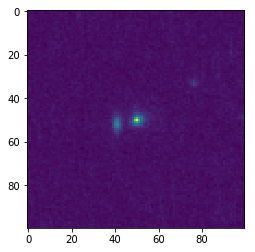

c_186.81908440026143_23.947122839906193.fits|| logscale =18, log black=19, exit=20, 20


In [5]:
# closer inspection
from IPython import display
from astropy.visualization import (ZScaleInterval, ImageNormalize)

import os 
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
PATH = "/home/toyonaga/projects/def-sfabbro/toyonaga/HSTLens/CC_batch_processing/class_1/"#HSTLens_detections/"
for filename in os.listdir(PATH):
    try:  
        data, hdr = fits.getdata(PATH + filename, 0, header=True) #'sci' image[1] data and header
        exit=False
       

        ims=data

        display.clear_output(wait=True)
        
        plt.imshow((ims)) 
        plt.pause(0.10)
        while(1):
            ans = int(input(filename+"|| logscale =18, log black=19, exit=20,"))

            if ans ==18:
                plt.imshow(np.log10(ims+1)) 
                plt.pause(0.1)
            if ans ==19:
                plt.imshow(np.log10(ims+1),cmap='gray') 
                plt.pause(0.1)
            if ans ==20:
                exit=True
                break
            if ans ==21:
                norm = ImageNormalize(ims, interval = ZScaleInterval())
                plt.imshow(ims,norm=norm,cmap='gray') 
                plt.pause(0.1)
        if exit==True:
            break
    except:
        print("skipped due to non-existent image, or conversion error")
        
        

    if exit==True:
        break



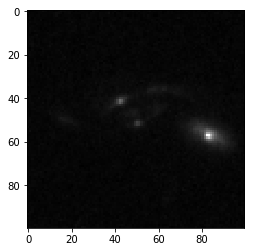

In [29]:
PATH = "/home/toyonaga/projects/def-sfabbro/toyonaga/HSTLens/CC_batch_processing/class_1/"#/good_quality/"#HSTLens_detections/"

data, hdr = fits.getdata(PATH + 'c_189.1720726077293_62.195145751291975.fits', 0, header=True) #'sci' image[1] data and header
norm = ImageNormalize(data, interval = ZScaleInterval())
plt.imshow(data,cmap='gray')